 # Delayed Flights Neural Network

In [6]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

#  Import and read data.
import pandas as pd 
data = "https://airport-efficiency.s3.amazonaws.com/Merged_cleaned_airport_data.csv"
df = pd.read_csv(data)
df.head()

,YEAR,MONTH,DAY_OF_WEEK,BRANDED_CODE_SHARE,ORIGIN,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED,DATE,COVID,DELAY_REASON
0,2018,1,1,UA,BWI,DEN,Colorado,1608,1600.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
1,2018,1,1,UA,BWI,ORD,Illinois,1644,1637.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
2,2018,1,1,UA,BWI,IAH,Texas,1806,1800.0,-6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
3,2018,1,1,UA,BWI,IAH,Texas,828,828.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0
4,2018,1,1,UA,BWI,DEN,Colorado,810,802.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0


In [7]:
# Combined Airline and their Codeshare
df.loc[(df.BRANDED_CODE_SHARE == "UA_CODESHARE"), "BRANDED_CODE_SHARE"] = "UA"
df.loc[(df.BRANDED_CODE_SHARE == "AA_CODESHARE"), "BRANDED_CODE_SHARE"] = "AA"
df.loc[(df.BRANDED_CODE_SHARE == "DL_CODESHARE"), "BRANDED_CODE_SHARE"] = "DL"
df.loc[(df.BRANDED_CODE_SHARE == "AS_CODESHARE"), "BRANDED_CODE_SHARE"] = "AS"

In [8]:
# Define regions
northeast = ['Massachusetts',
'Rhode Island',
'Connecticut',
'Vermont',
'New Hampshire',
'Maine',
'Pennsylvania',
'New Jersey',
'New York'
]

souteast = ['Georgia',
'North Carolina',
'South Carolina',
'Virginia',
'West Virginia',
'Kentucky',
'Tennessee',
'Mississippi',
'Alabama',
'Delaware',
'Maryland',
'Florida',
'Louisiana',
'Arkansas'
]

midwest = ['Minnesota',
'Wisconsin',
'Illinois',
'Ohio',
'Indiana',
'Michigan',
'Missouri',
'Iowa',
'Kansas',
'Nebraska',
'North Dakota',
'South Dakota'
]

southwest = ['New Mexico',
'Arizona',
'Oklahoma',
'Texas'
]

west = ['California',
'Colorado',
'Nevada',
'Hawaii',
'Alaska',
'Oregon',
'Utah',
'Idaho',
'Montana',
'Wyoming',
'Washington'
]

noncontinental = ['U.S. Virgin Islands',
'Puerto Rico'
]

In [9]:
# Add region column
regions=pd.DataFrame([northeast,souteast,midwest,southwest,west,noncontinental],index=['northeast','souteast','midwest','southwest','west','noncontinental'])
regions=regions.reset_index().melt('index')
df['Region'] = df['DEST_STATE_NM'].map(dict(zip(regions['value'],regions['index'])))

In [10]:
# drop more columns
drop = ['DEP_TIME','DEP_DELAY_GROUP',  'DEST_STATE_NM', 'DEST', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'DELAY_REASON', 'CRS_DEP_TIME' ]
df_dropped = df.drop( drop , 1)

C:\Users\nizar\AppData\Local\Temp\ipykernel_30928\2501623100.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_dropped = df.drop( drop , 1)


# Encode Columns 
using get_dummies

In [11]:
brand_df = pd.get_dummies(df_dropped, columns=["BRANDED_CODE_SHARE"])


In [12]:
origin_df = pd.get_dummies(brand_df, columns=["ORIGIN"])

In [13]:
region_df = pd.get_dummies(origin_df, columns=["Region"])

In [14]:
final_df = pd.get_dummies(region_df, columns=["DEP_TIME_BLK"])
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format='%Y-%m-%d')
final_df['DAY_OF_MONTH'] = final_df.DATE.dt.day
final_df = final_df.drop('DATE', 1)


C:\Users\nizar\AppData\Local\Temp\ipykernel_30928\381400624.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_df = final_df.drop('DATE', 1)


In [15]:
y = final_df["DELAYED"]
X = final_df.drop(columns=["DELAYED"])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaler = sc.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# hidden layers determined using 2/3 of input layer + output layer for first layer then halving for each following layer
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  number_input_features*(2/3)+2
hidden_nodes_layer2 = hidden_nodes_layer1/2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1472      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=20)

Epoch 1/20
25382/25382 [==============================] - 20s 764us/step - loss: 0.4366 - accuracy: 0.8243
Epoch 2/20
25382/25382 [==============================] - 20s 777us/step - loss: 0.4300 - accuracy: 0.8262
Epoch 3/20
25382/25382 [==============================] - 22s 853us/step - loss: 0.4272 - accuracy: 0.8266
Epoch 4/20
25382/25382 [==============================] - 19s 759us/step - loss: 0.4260 - accuracy: 0.8268
Epoch 5/20
25382/25382 [==============================] - 19s 756us/step - loss: 0.4254 - accuracy: 0.8269
Epoch 6/20
25382/25382 [==============================] - 20s 786us/step - loss: 0.4248 - accuracy: 0.8271
Epoch 7/20
25382/25382 [==============================] - 19s 746us/step - loss: 0.4243 - accuracy: 0.8272
Epoch 8/20
25382/25382 [==============================] - 19s 737us/step - loss: 0.4240 - accuracy: 0.8271
Epoch 9/20
25382/25382 [==============================] - 18s 716us/step - loss: 0.4237 - accuracy: 0.8274
Epoch 10/20
25382/25382 [============

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8461/8461 - 4s - loss: 0.4232 - accuracy: 0.8275 - 4s/epoch - 454us/step
Loss: 0.423189252614975, Accuracy: 0.8274807333946228


# Make Predictions

In [20]:
predictions = nn.predict(X_test_scaled)

8461/8461 [==============================] - 4s 460us/step


In [21]:
print(predictions[0:10])

[[0.1301846 ]
 [0.11771213]
 [0.14656152]
 [0.08627734]
 [0.08917167]
 [0.21916498]
 [0.14476912]
 [0.14579043]
 [0.12292942]
 [0.11438985]]


In [22]:
# Round predictions to be able to compare test data
rounded = [round(x[0]) for x in predictions]
print(rounded[0:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Validate the model using the test data

In [23]:
y_test.value_counts()

0.0    222850
1.0     47885
Name: DELAYED, dtype: int64

In [24]:

# Calculating the confusion matrix
cm = confusion_matrix(y_test, rounded, labels=[1, 0])
cm_df = pd.DataFrame(
    cm, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rounded)

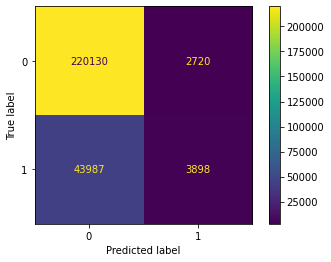

In [25]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, rounded, labels=[0, 1]))
cm.plot()
plt.show()

In [27]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, rounded))

Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),3898,43987
Actual On-Time (0),2720,220130


Accuracy Score : 0.8274807468557814
Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    222850
         1.0       0.59      0.08      0.14     47885

    accuracy                           0.83    270735
   macro avg       0.71      0.53      0.52    270735
weighted avg       0.79      0.83      0.77    270735



# Feature Correlation

In [52]:
import seaborn as sns

C:\Users\nizar\AppData\Local\Temp\ipykernel_30928\3732277149.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

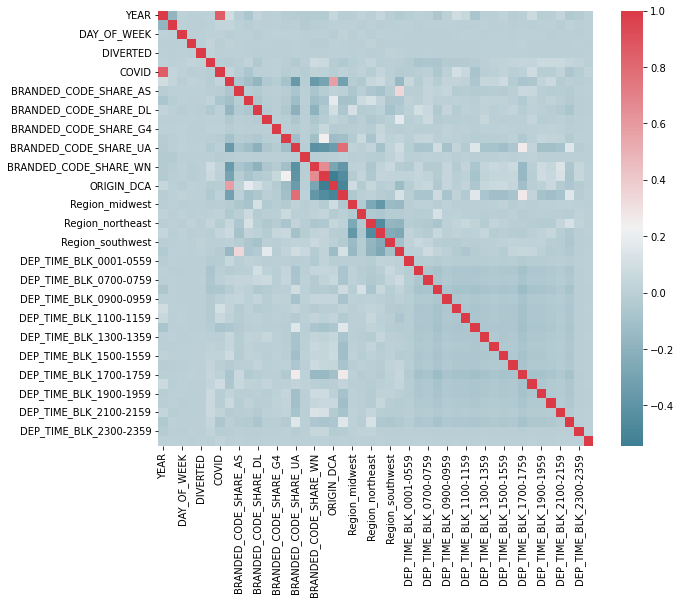

In [33]:
# run correlation matrix and plot
f, ax = plt.subplots(figsize=(10, 8))
corr = final_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [92]:
import shap 

In [104]:
train_scaled.head()

,YEAR,MONTH,DAY_OF_WEEK,CANCELLED,DIVERTED,COVID,BRANDED_CODE_SHARE_AA,BRANDED_CODE_SHARE_AS,BRANDED_CODE_SHARE_B6,BRANDED_CODE_SHARE_DL,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,DAY_OF_MONTH
0,1.973212,-1.246154,1.530346,-0.02737,-0.045554,1.261843,1.789290,-0.117464,-0.19056,-0.307856,...,-0.238773,-0.217115,-0.383519,-0.243512,-0.239535,-0.197797,-0.1384,-0.244053,-0.031984,0.487441
1,-1.242389,-0.686146,-1.475313,-0.02737,-0.045554,-0.792492,-0.558881,-0.117464,-0.19056,3.248269,...,-0.238773,4.605844,-0.383519,-0.243512,-0.239535,-0.197797,-0.1384,-0.244053,-0.031984,0.030334
2,-0.438488,-1.246154,-1.475313,-0.02737,-0.045554,-0.792492,1.789290,-0.117464,-0.19056,-0.307856,...,-0.238773,-0.217115,2.607431,-0.243512,-0.239535,-0.197797,-0.1384,-0.244053,-0.031984,-1.340987
3,1.169312,0.153866,0.027517,-0.02737,-0.045554,1.261843,-0.558881,-0.117464,-0.19056,-0.307856,...,-0.238773,-0.217115,-0.383519,-0.243512,-0.239535,-0.197797,-0.1384,-0.244053,-0.031984,-1.683817
4,1.169312,1.273882,-0.974369,-0.02737,-0.045554,1.261843,-0.558881,-0.117464,-0.19056,-0.307856,...,-0.238773,-0.217115,-0.383519,-0.243512,-0.239535,-0.197797,-0.1384,-0.244053,-0.031984,1.630208


In [125]:
explainer = shap.KernelExplainer(nn.predict,shap.sample(X_train_scaled,1000))

32/32 [==============================] - 0s 496us/step


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [129]:
shap_values = explainer.shap_values(shap.sample(X_test_scaled,10))

  0%|          | 0/10 [00:00<?, ?it/s]

66625/66625 [==============================] - 36s 540us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 10%|█         | 1/10 [00:52<07:52, 52.51s/it]

66625/66625 [==============================] - 35s 518us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 20%|██        | 2/10 [01:43<06:53, 51.71s/it]

66625/66625 [==============================] - 36s 534us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 30%|███       | 3/10 [02:37<06:07, 52.50s/it]

66625/66625 [==============================] - 34s 515us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|████      | 4/10 [03:27<05:10, 51.83s/it]

66625/66625 [==============================] - 34s 516us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 50%|█████     | 5/10 [04:19<04:18, 51.65s/it]

66625/66625 [==============================] - 35s 527us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 60%|██████    | 6/10 [05:11<03:27, 51.95s/it]

66625/66625 [==============================] - 35s 526us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 70%|███████   | 7/10 [06:04<02:36, 52.07s/it]

66625/66625 [==============================] - 35s 529us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|████████  | 8/10 [06:56<01:44, 52.08s/it]

66625/66625 [==============================] - 35s 523us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 90%|█████████ | 9/10 [07:47<00:51, 51.83s/it]

66625/66625 [==============================] - 35s 527us/step


The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
100%|██████████| 10/10 [08:38<00:00, 51.89s/it]


In [133]:
shap_values

[array([[-2.13253307e-02, -1.03696457e-02,  1.03554618e-03,
          0.00000000e+00,  1.18116898e-03,  3.19635753e-02,
          9.85404283e-03,  3.39777511e-04,  2.12107169e-03,
          3.78638797e-03,  0.00000000e+00,  0.00000000e+00,
          2.14487445e-03, -2.96715359e-02,  0.00000000e+00,
          1.48182268e-02,  0.00000000e+00,  6.57744722e-04,
          9.59824620e-03,  5.75004571e-03,  5.13267718e-04,
         -4.70787388e-03,  1.04169338e-02,  3.07374365e-03,
          5.06167894e-03,  1.75378140e-03,  7.26043138e-03,
         -1.96267637e-01,  1.28590490e-02,  5.22276374e-03,
          8.66005580e-03,  7.60628339e-03,  7.77834368e-03,
          4.46960543e-03,  3.09800392e-03,  3.47208516e-03,
          4.58265640e-03,  7.51913746e-03,  2.22761876e-03,
          4.80510873e-04,  1.33214438e-03,  0.00000000e+00,
          2.42042137e-03,  0.00000000e+00,  5.19843684e-04],
        [-4.17447870e-02, -2.57924720e-02, -2.33062558e-02,
          0.00000000e+00,  0.00000000e+

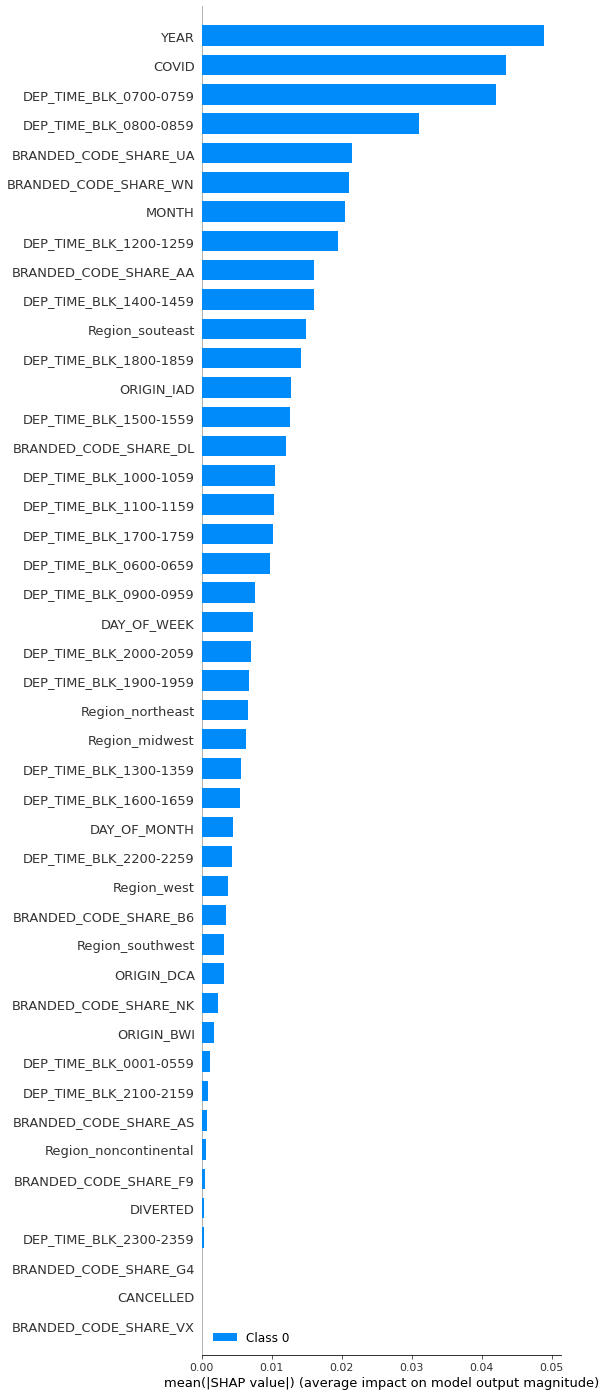

In [145]:
shap.summary_plot(shap_values,shap.sample(X_test_scaled,10),feature_names=X_test.columns.values, max_display = X_test.shape[1] )

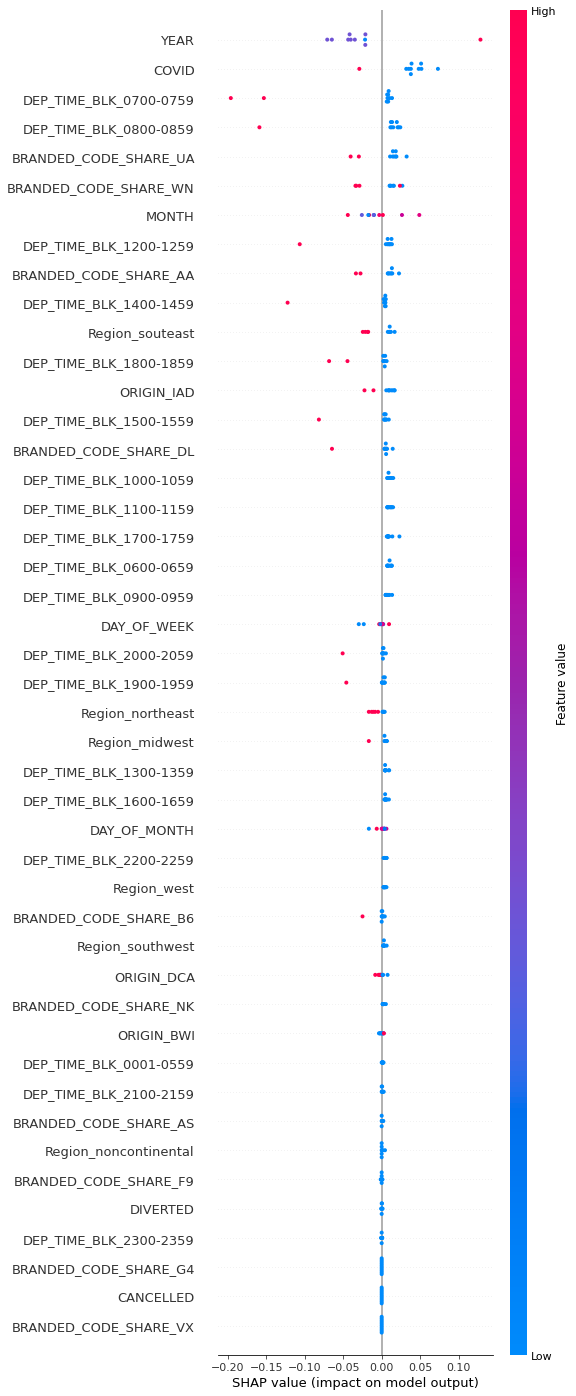

In [150]:
shap.summary_plot(shap_values[0],shap.sample(X_test_scaled,10),feature_names=X_test.columns.values, max_display = X_test.shape[1] )